In [25]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix
import shap 
import matplotlib.pyplot as plt 

df = pd.read_csv('C:/Python Software/Water Quality/water_potability.csv')

## Remove Missing Value
def remove_missing(self):
    X = df.iloc[:, :-1]
    for col in X.columns:
        Avg = X[col].mean()
        X.fillna(Avg, inplace = True)
    return X

X = list(map(remove_missing, df))[0]
## Train_test_split
X.drop(['Solids'], axis = 1, inplace = True)
y = df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .1, random_state = 5)
##XGB
XGB = XGBClassifier(num_class = 2)

params = {'booster': ['gbtree'],
          'objective': ['multi:softmax'], ##binary: logistic,
          #'objective': ['binary:logistic'],
          'n_estimators': [i for i in range(5, 50, 2)],
          'max_depth': [i for i in range(10, 100, 5)],
          'learning_rate':[10e-5, 10e-4, 10e-3, 10e-2, .1, .3, .5, 1],
          'min_child_weight': [.1, 1, 3, 5, 7, 9],
          'gamma': [10e-2, 10e-1, .3, .5, .7, 1, 2, 5],
          'reg_lambda': [.1, .2, .4, .6, .7, .8, .9]
          }

rscv = RandomizedSearchCV(XGB, param_distributions = params, scoring = 'accuracy',
                         n_iter = 10, cv = 5, n_jobs = -1, random_state = 5)
rscv.fit(X_train, y_train)

print(f'Best Estimator is: {rscv.best_estimator_} \n Best Score is: {rscv.best_score_}')

##RSCV XGB Fit
rscv.best_estimator_.fit(X_train, y_train, early_stopping_rounds = 100, 
                        eval_set = [(X_train, y_train), (X_test, y_test)],
                        eval_metric = 'merror') #eval_metrics = 'error' or 'merror'

Best Estimator is: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=55,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=47, n_jobs=0, num_class=2, num_parallel_tree=1,
              objective='multi:softmax', random_state=0, reg_alpha=0,
              reg_lambda=0.4, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None) 
 Best Score is: 0.6366890161434204
[0]	validation_0-merror:0.16757	validation_1-merror:0.37500
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 100 rounds.
[1]	validation_0-merror:0.12347	validation_1-merror:0.36280
[2]	validation_0-merror:0.11

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=55,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=47, n_jobs=0, num_class=2, num_parallel_tree=1,
              objective='multi:softmax', random_state=0, reg_alpha=0,
              reg_lambda=0.4, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

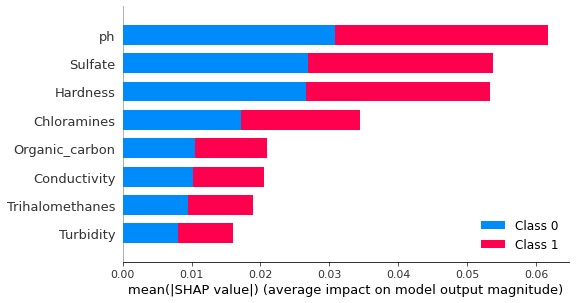

In [26]:
##Shapley Value
Explainer = shap.TreeExplainer(rscv.best_estimator_)
shap_value = Explainer.shap_values(X_test)
shap.initjs()
shap.summary_plot(shap_values = shap_value, features = X_test, feature_names = X.columns)

In [29]:
shap.force_plot(Explainer.expected_value[0], shap_value[0], X_test)